<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/Various_model_to_predict_Kospi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, RepeatVector, TimeDistributed, Flatten, Dropout, MaxPooling1D, Activation, LeakyReLU, PReLU
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
filename = '/content/drive/MyDrive/Financial_data/Data/train/kospi_train_data.csv'
data = pd.read_csv(filename, sep=",",encoding='UTF-8')
data.head()

,Date,End,Open,High,Low,Amount,Val
0,2020년 02월 21일,"2,162.84","2,165.65","2,184.43","2,160.28",635.47M,-1.49%
1,2020년 02월 20일,"2,195.50","2,223.55","2,228.18","2,186.72",709.56M,-0.67%
2,2020년 02월 19일,"2,210.34","2,222.51","2,226.00","2,191.20",591.16M,0.07%
3,2020년 02월 18일,"2,208.88","2,225.98","2,232.93","2,205.21",470.42M,-1.48%
4,2020년 02월 17일,"2,242.17","2,243.07","2,250.05","2,230.26",458.25M,-0.06%


In [ ]:
date_index = data
date_index = date_index.copy()

In [ ]:
date_index['Date'] = date_index.Date.apply(str).str.replace("년","").str.replace("월","").str.replace("일","")
date_index['Date'] = date_index.Date.str.replace(" ","")

date_index['Amount'] = date_index.Amount.apply(str).str.replace("B", "0000000").str.replace("M","0000").str.replace("K","0").str.replace(".","")
date_index['Amount'] = date_index.Amount.astype(int)
date_index['Val'] = date_index.Val.apply(str).str.replace("%", "")
date_index['Val'] = date_index.Val.astype(float)
date_index['End'] = date_index.End.apply(str).str.replace(",","").astype(float)
date_index['Open'] = date_index.Open.apply(str).str.replace(",","").astype(float)
date_index['High'] = date_index.High.apply(str).str.replace(",","").astype(float)
date_index['Low'] = date_index.Low.apply(str).str.replace(",","").astype(float)

date_index = date_index.loc[::-1].reset_index(drop=True)
date_time = pd.to_datetime(date_index.pop('Date'))
date_index.tail()


,End,Open,High,Low,Amount,Val
10383,2242.17,2243.07,2250.05,2230.26,458250000,-0.06
10384,2208.88,2225.98,2232.93,2205.21,470420000,-1.48
10385,2210.34,2222.51,2226.00,2191.20,591160000,0.07
10386,2195.50,2223.55,2228.18,2186.72,709560000,-0.67
10387,2162.84,2165.65,2184.43,2160.28,635470000,-1.49


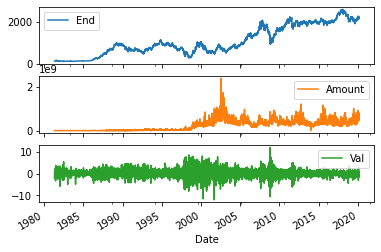

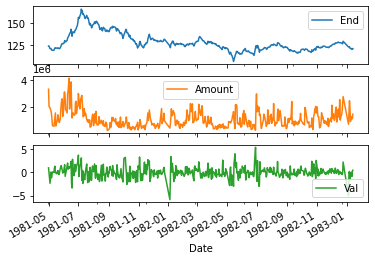

In [ ]:
plot_cols = ['End', 'Amount', 'Val']
plot_features = date_index[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
#전체적인 데이터 출력
plot_features = date_index[plot_cols][:500]
plot_features.index = date_time[:500]
_ = plot_features.plot(subplots=True)
#데이터의 일부분만 출력하여 데이터의 특성을 추출
#Val, Amount의 경우 가끔 Shooting이 일어나는 값을 제외하고 일정한 범위내에 존재 함

In [ ]:
print(date_index)
print(date_index.shape)

           End     Open     High      Low     Amount   Val
0       123.60   123.60   123.60   123.60    3330000  0.98
1       123.50   123.50   123.50   123.50    2040000 -0.08
2       120.60   120.60   120.60   120.60    1930000 -2.35
3       120.70   120.70   120.70   120.70    1690000  0.08
4       119.30   119.30   119.30   119.30    1480000 -1.16
...        ...      ...      ...      ...        ...   ...
10383  2242.17  2243.07  2250.05  2230.26  458250000 -0.06
10384  2208.88  2225.98  2232.93  2205.21  470420000 -1.48
10385  2210.34  2222.51  2226.00  2191.20  591160000  0.07
10386  2195.50  2223.55  2228.18  2186.72  709560000 -0.67
10387  2162.84  2165.65  2184.43  2160.28  635470000 -1.49

[10388 rows x 6 columns]
(10388, 6)


In [ ]:
date_index.describe()

,End,Open,High,Low,Amount,Val
count,10388.000000,10388.000000,10388.000000,10388.000000,1.038800e+04,10388.000000
mean,1028.213099,1028.629756,1033.878016,1022.224383,2.175911e+08,0.038568
std,683.773007,684.222797,687.160231,679.985052,2.371764e+08,1.457766
min,105.990000,105.990000,105.990000,105.990000,1.660000e+05,-12.020000
25%,565.195000,565.175000,569.615000,558.530000,1.038000e+07,-0.622500
50%,847.615000,847.860000,853.475000,840.665000,1.765450e+08,0.030000
75%,1720.612500,1721.410000,1732.810000,1707.807500,3.758325e+08,0.712500
max,2598.190000,2590.410000,2607.100000,2587.550000,2.380000e+09,11.950000


In [ ]:
column_indices = {name: i for i, name in enumerate(date_index.columns)}

n = len(date_index)
train_df = date_index[0:int(n*0.7)]
val_df = date_index[int(n*0.7):int(n*0.9)]
test_df = date_index[int(n*0.9):]

num_features = date_index.shape[1]

In [ ]:
print(train_df)

          End     Open     High      Low     Amount   Val
0      123.60   123.60   123.60   123.60    3330000  0.98
1      123.50   123.50   123.50   123.50    2040000 -0.08
2      120.60   120.60   120.60   120.60    1930000 -2.35
3      120.70   120.70   120.70   120.70    1690000  0.08
4      119.30   119.30   119.30   119.30    1480000 -1.16
...       ...      ...      ...      ...        ...   ...
7266  1847.79  1841.56  1865.52  1836.93  534040000  0.51
7267  1861.01  1855.03  1863.01  1838.75  414380000  0.72
7268  1883.59  1870.35  1890.83  1865.79  430590000  1.21
7269  1894.53  1887.35  1895.98  1881.36  406270000  0.58
7270  1889.96  1880.71  1904.35  1875.43  473880000 -0.24

[7271 rows x 6 columns]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 변형 객체 생성
minmax_scaler = MinMaxScaler()

# 훈련데이터의 모수 분포 저장
minmax_scaler.fit(train_df)

# 훈련 데이터 스케일링
X_train_scaled = minmax_scaler.transform(train_df)

X_train_scaled.

SyntaxError: ignored

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

#Min-Max Scaling
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
print(train_df)
print(val_df)

           End      Open      High       Low    Amount       Val
0    -1.474065 -1.474174 -1.475191 -1.473744 -0.595490  0.601218
1    -1.474352 -1.474461 -1.475477 -1.474034 -0.601059 -0.084041
2    -1.482694 -1.482802 -1.483768 -1.482432 -0.601533 -1.551530
3    -1.482406 -1.482514 -1.483482 -1.482143 -0.602569  0.019394
4    -1.486433 -1.486541 -1.487484 -1.486197 -0.603476 -0.782230
...        ...       ...       ...       ...       ...       ...
7266  3.485398  3.466699  3.504494  3.488076  1.695228  0.297377
7267  3.523424  3.505439  3.497318  3.493347  1.178736  0.433136
7268  3.588373  3.549499  3.576848  3.571655  1.248704  0.749906
7269  3.619841  3.598392  3.591571  3.616746  1.143730  0.342630
7270  3.606695  3.579295  3.615498  3.599573  1.435557 -0.187477

[7271 rows x 6 columns]
           End      Open      High       Low    Amount           Val
7271  3.663619  3.627842  3.666670  3.663748  1.313233  6.464709e-01
7272  3.816586  3.767300  3.782992  3.791057  1.580974  1

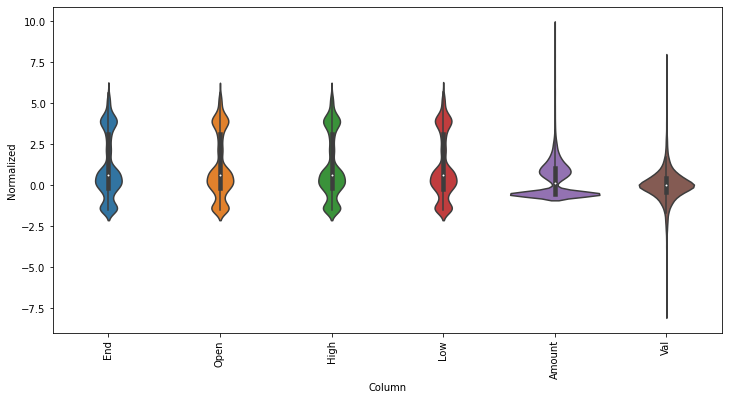

In [ ]:
df_std = (date_index - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(date_index.keys(), rotation=90)

##Stacked Autoencoder

In [ ]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, activation = 'relu', input_shape = (6,)),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = None)
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation = 'relu', input_shape = (2,)),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = None)
])

autoencoder = tf.keras.models.Sequential([encoder, decoder])

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(0.01),
                    loss = 'mean_squared_error',
                    metrics = ['mse', "accuracy"])

In [ ]:
training = autoencoder.fit(train_df,train_df, batch_size = 20, epochs = 50, validation_data=(val_df, val_df))

Epoch 1/50
364/364 [==============================] - 2s 3ms/step - loss: 0.3882 - mse: 0.3882 - accuracy: 0.3733 - val_loss: 0.5932 - val_mse: 0.5932 - val_accuracy: 0.3436
Epoch 2/50
364/364 [==============================] - 1s 2ms/step - loss: 0.2181 - mse: 0.2181 - accuracy: 0.4969 - val_loss: 0.4499 - val_mse: 0.4499 - val_accuracy: 0.2873
Epoch 3/50
364/364 [==============================] - 1s 2ms/step - loss: 0.1688 - mse: 0.1688 - accuracy: 0.5607 - val_loss: 0.3952 - val_mse: 0.3952 - val_accuracy: 0.2464
Epoch 4/50
364/364 [==============================] - 1s 2ms/step - loss: 0.1616 - mse: 0.1616 - accuracy: 0.5862 - val_loss: 0.3351 - val_mse: 0.3351 - val_accuracy: 0.2401
Epoch 5/50
364/364 [==============================] - 1s 2ms/step - loss: 0.1527 - mse: 0.1527 - accuracy: 0.5245 - val_loss: 0.4154 - val_mse: 0.4154 - val_accuracy: 0.3378
Epoch 6/50
364/364 [==============================] - 1s 2ms/step - loss: 0.1445 - mse: 0.1445 - accuracy: 0.5148 - val_loss: 0.42

In [ ]:
test_scores = autoencoder.evaluate(train_df, train_df, verbose = 2)
print('Test loss: {}'.format(test_scores[0]))
print('Mean Squared Error: {} %'.format(test_scores[1]*100))

228/228 - 0s - loss: 0.0379 - mse: 0.0379 - accuracy: 0.7937 - 256ms/epoch - 1ms/step
Test loss: 0.03790084272623062
Mean Squared Error: 3.790084272623062 %


In [ ]:
print(training.history['val_loss'])


[0.5931901931762695, 0.4499076008796692, 0.39523613452911377, 0.3351362645626068, 0.415449321269989, 0.4295680820941925, 0.3060953915119171, 0.4377685785293579, 0.39052459597587585, 0.7492864727973938, 0.6022214293479919, 0.6775478720664978, 0.466972678899765, 0.32288411259651184, 0.32193347811698914, 0.39106762409210205, 0.29126402735710144, 0.36538243293762207, 0.3490857183933258, 0.3317981958389282, 0.4116676151752472, 0.26023995876312256, 0.24042075872421265, 0.3274444341659546, 0.4611373543739319, 0.3714959919452667, 0.2872827649116516, 0.3010483980178833, 0.33992114663124084, 0.24646879732608795, 0.3244646489620209, 0.3655940890312195, 0.5288877487182617, 0.35349786281585693, 0.30385419726371765, 0.2574773132801056, 0.26715269684791565, 0.291053831577301, 0.27618730068206787, 0.29145294427871704, 0.30212104320526123, 0.3366207182407379, 0.3133254945278168, 0.2739277780056, 0.5657148957252502, 0.3985927402973175, 0.38067492842674255, 0.413156121969223, 0.4620540738105774, 0.328379

No handles with labels found to put in legend.


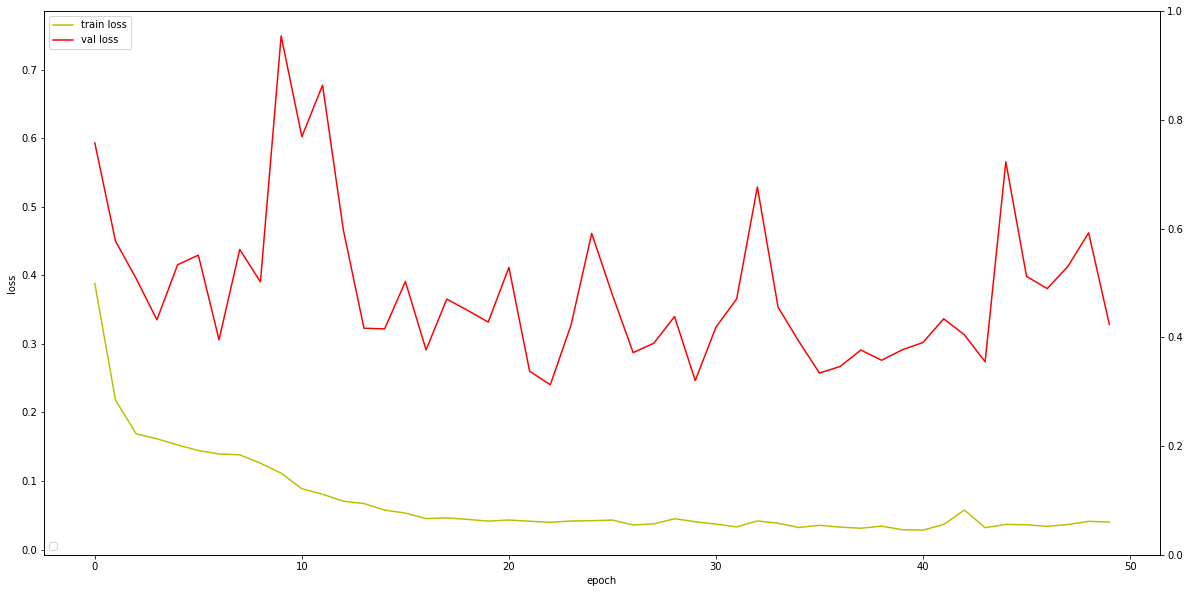

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(training.history['loss'], 'y', label = 'train loss')
loss_ax.plot(training.history['val_loss'], 'r', label = 'val loss')

#acc_ax.plot(training.history['accuracy'], 'b', label = 'train accuracy')
#acc_ax.plot(training.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

fig.set_size_inches(20,10)
plt.show()

In [ ]:
autoencoder_result = autoencoder.predict(train_df, verbose=0)
print(np.round(autoencoder_result,20))


[[-1.3848809  -1.3972952  -1.3960574  -1.3871256  -0.6884762   0.59402835]
 [-1.3969123  -1.399188   -1.4033651  -1.3937258  -0.7272823  -0.10604037]
 [-1.4291514  -1.4097203  -1.4254794  -1.4143554  -0.81100744 -1.6056465 ]
 ...
 [ 3.2879508   3.2678223   3.2748075   3.2701921   1.6264375   0.3138368 ]
 [ 3.2860458   3.2660143   3.2729228   3.268392    1.6202028   0.30907166]
 [ 3.2797587   3.2600462   3.2667022   3.2624493   1.5996186   0.2933389 ]]


In [ ]:
#print(type(autoencoder_result))
#print(type(train_df))
#train_df.loc[1:100].plot(y=['End'],xlabel="Date", ylabel="Price")
#plt.plot(autoencoder_result[1:100, 0], 'r', label = 'auto')


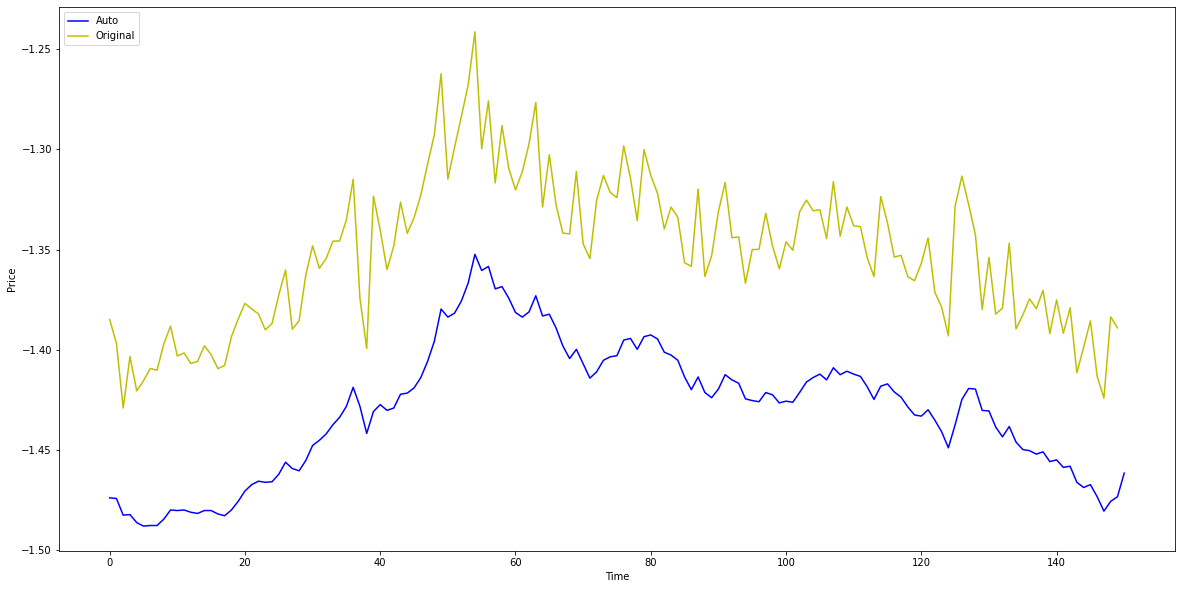

In [ ]:
fig, res = plt.subplots()

res.plot(train_df.loc[0:150, 'End'], 'b', label = 'Auto')
res.plot(autoencoder_result[0:150, 0], 'y', label = 'Original')

res.set_xlabel('Time')
res.set_ylabel('Price')
res.legend(loc='upper left')
fig.set_size_inches(20,10)

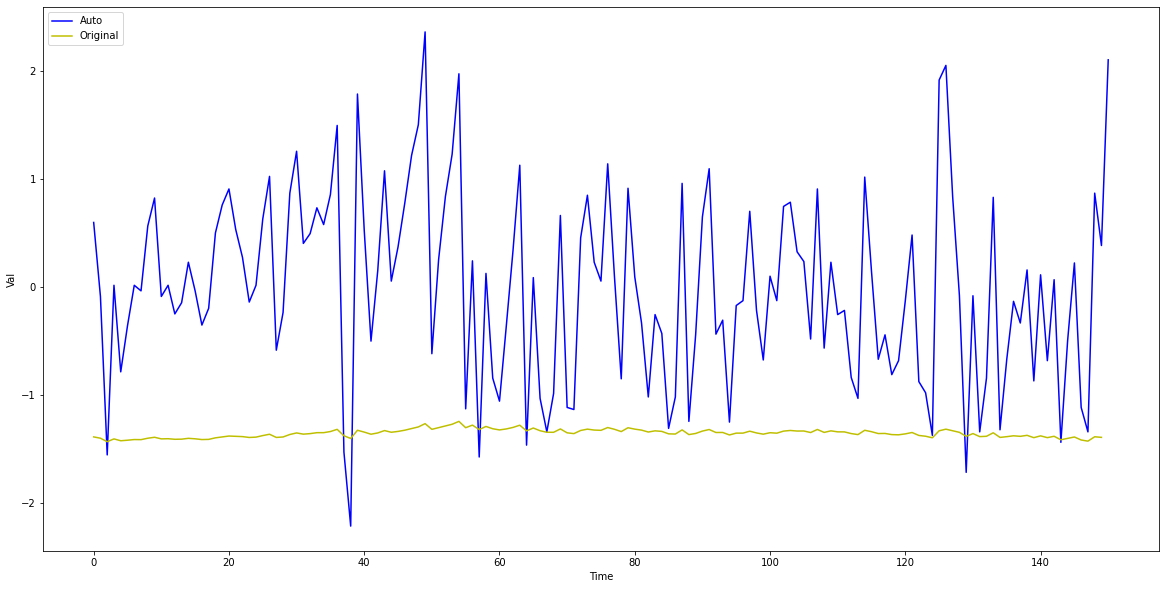

In [ ]:
fig, res = plt.subplots()

res.plot(train_df.loc[0:150, 'Val'], 'b', label = 'Auto')
res.plot(autoencoder_result[0:150, 0], 'y', label = 'Original')

res.set_xlabel('Time')
res.set_ylabel('Val')
res.legend(loc='upper left')
fig.set_size_inches(20,10)

In [ ]:
autoencoder_result_df = pd.DataFrame(autoencoder_result)
autoencoder_result_df.columns = ["End", "Open", "High", "Low", "Amount", "Val"]
train_df = autoencoder_result_df
train_df

,End,Open,High,Low,Amount,Val
0,-1.384881,-1.397295,-1.396057,-1.387126,-0.688476,0.594028
1,-1.396912,-1.399188,-1.403365,-1.393726,-0.727282,-0.106040
2,-1.429151,-1.409720,-1.425479,-1.414355,-0.811007,-1.605646
3,-1.403438,-1.407241,-1.410588,-1.401094,-0.722258,-0.001454
4,-1.420590,-1.412535,-1.422210,-1.411904,-0.767949,-0.820587
...,...,...,...,...,...,...
7266,3.312490,3.291115,3.299087,3.293386,1.706779,0.375242
7267,3.290219,3.269974,3.277051,3.272335,1.633863,0.319512
7268,3.287951,3.267822,3.274808,3.270192,1.626438,0.313837
7269,3.286046,3.266014,3.272923,3.268392,1.620203,0.309072


In [ ]:
autoencoder_mean = autoencoder_result_df.mean()
autoencoder_std = autoencoder_result_df.std()

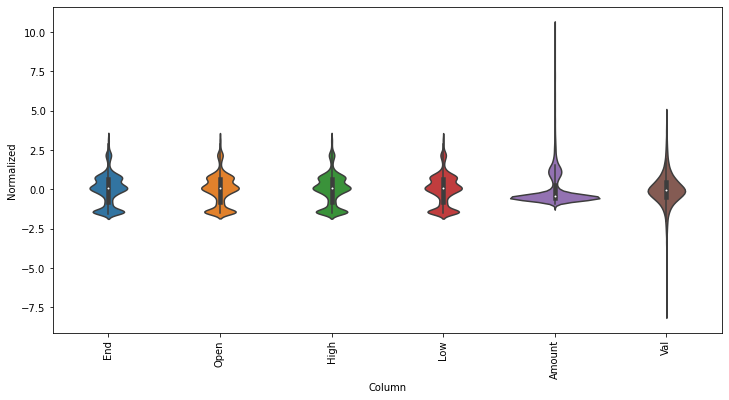

In [ ]:
df_std = (autoencoder_result_df - autoencoder_mean) / autoencoder_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(date_index.keys(), rotation=90)

#인덱스 및 오프셋

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

7일간의 입력으로 1일의 예측치 생성

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                   label_columns=['End'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['End']

#분할
Split_window가 입력 창과 레이블 창으로 변환


In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)
print(w2.total_window_size)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}') #특성, 시간, 여러 예제

7
All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels


In [ ]:
def plot(self, model=None, plot_col='End', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

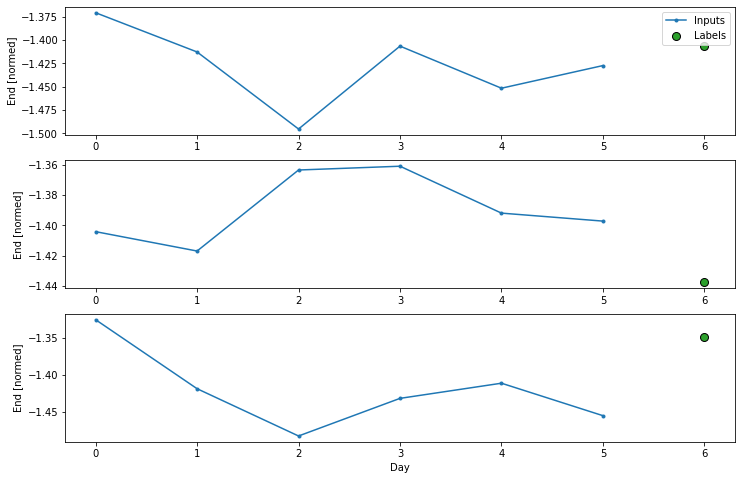

In [ ]:
w2.plot()


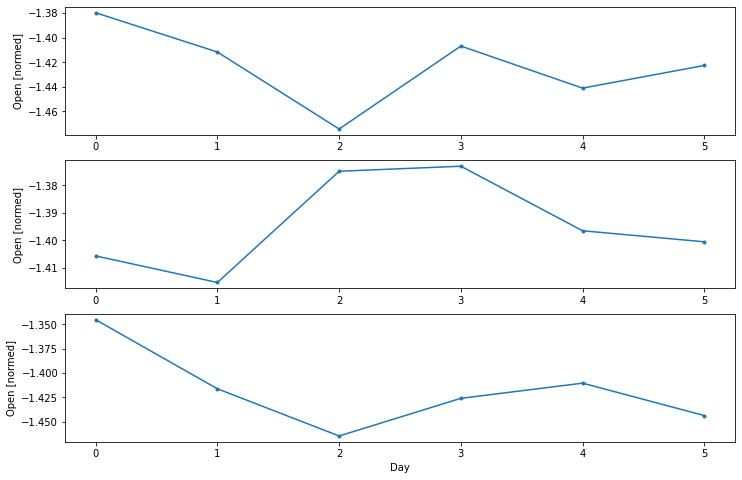

In [ ]:
w2.plot(plot_col='Open')

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['End'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['End']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


#Baseline 

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['End'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['End']

In [ ]:
baseline = Baseline(label_index=column_indices['End'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

65/65 [==============================] - 0s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0459


In [ ]:
wide_window = WindowGenerator(
    input_width=200, label_width=200, shift=1,
    label_columns=['End'])

wide_window

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33 

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [ ]:
print('Input shape:',wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 200, 6)
Output shape: (32, 200, 1)


Single step

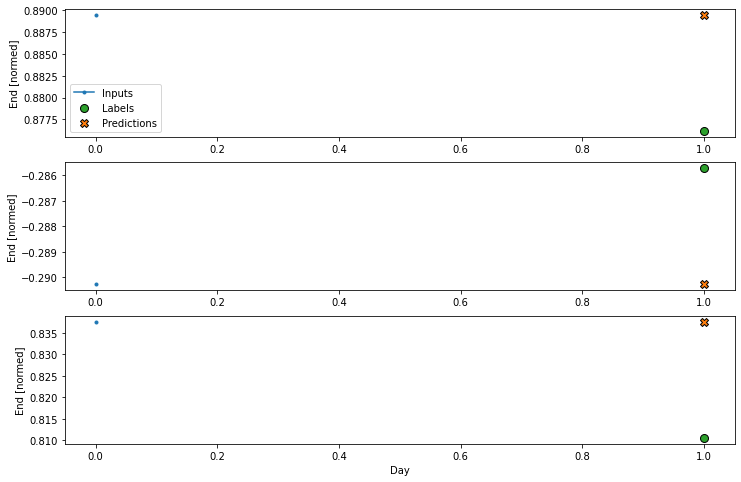

In [ ]:
single_step_window.plot(baseline)

Wide_window 예측(baseline)

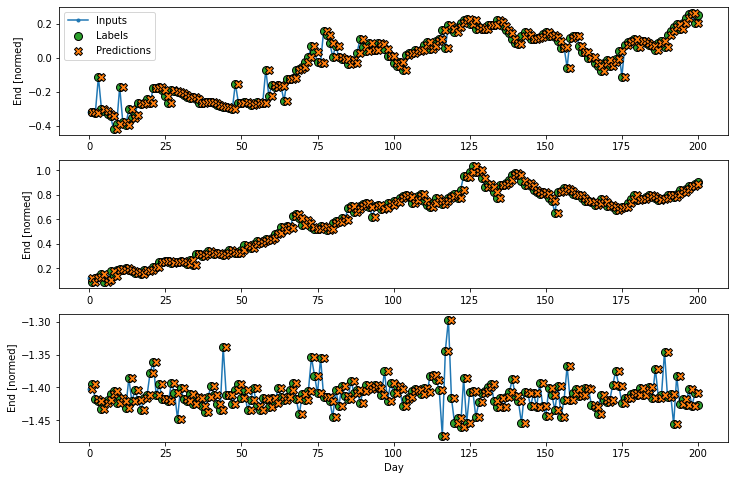

In [ ]:
wide_window.plot(baseline)

#Linear

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


Model 제작 후 Single window로 예측(Linear)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                #metrics=[tf.metrics.MeanAbsoluteError()]
                metrics=['accuracy'])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
228/228 [==============================] - 2s 6ms/step - loss: 9.0268 - mean_absolute_error: 2.4146 - val_loss: 70.8507 - val_mean_absolute_error: 8.2644
Epoch 2/20
228/228 [==============================] - 2s 6ms/step - loss: 4.6653 - mean_absolute_error: 1.7329 - val_loss: 33.9342 - val_mean_absolute_error: 5.7206
Epoch 3/20
228/228 [==============================] - 1s 5ms/step - loss: 2.1689 - mean_absolute_error: 1.1785 - val_loss: 14.1557 - val_mean_absolute_error: 3.6958
Epoch 4/20
228/228 [==============================] - 1s 5ms/step - loss: 0.8939 - mean_absolute_error: 0.7550 - val_loss: 5.0304 - val_mean_absolute_error: 2.2037
Epoch 5/20
228/228 [==============================] - 1s 5ms/step - loss: 0.3309 - mean_absolute_error: 0.4585 - val_loss: 1.4699 - val_mean_absolute_error: 1.1907
Epoch 6/20
228/228 [==============================] - 2s 9ms/step - loss: 0.1200 - mean_absolute_error: 0.2714 - val_loss: 0.3446 - val_mean_absolute_error: 0.5737
Epoch 7/20
22

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


Wide window로 예측(Linear)

In [ ]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 2s 6ms/step - loss: 0.5756 - accuracy: 0.0000e+00 - val_loss: 0.2484 - val_accuracy: 0.0000e+00
Epoch 2/20
221/221 [==============================] - 1s 5ms/step - loss: 0.3130 - accuracy: 0.0000e+00 - val_loss: 0.1299 - val_accuracy: 0.0000e+00
Epoch 3/20
221/221 [==============================] - 1s 6ms/step - loss: 0.1740 - accuracy: 0.0000e+00 - val_loss: 0.0684 - val_accuracy: 0.0000e+00
Epoch 4/20
221/221 [==============================] - 1s 6ms/step - loss: 0.0967 - accuracy: 0.0000e+00 - val_loss: 0.0360 - val_accuracy: 0.0000e+00
Epoch 5/20
221/221 [==============================] - 1s 6ms/step - loss: 0.0557 - accuracy: 0.0000e+00 - val_loss: 0.0205 - val_accuracy: 0.0000e+00
Epoch 6/20
221/221 [==============================] - 2s 9ms/step - loss: 0.0360 - accuracy: 0.0000e+00 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 7/20
221/221 [==============================] - 3s 12ms/step - loss: 0.0278 - accuracy: 0.0000

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 200, 6)
Output shape: (32, 200, 1)


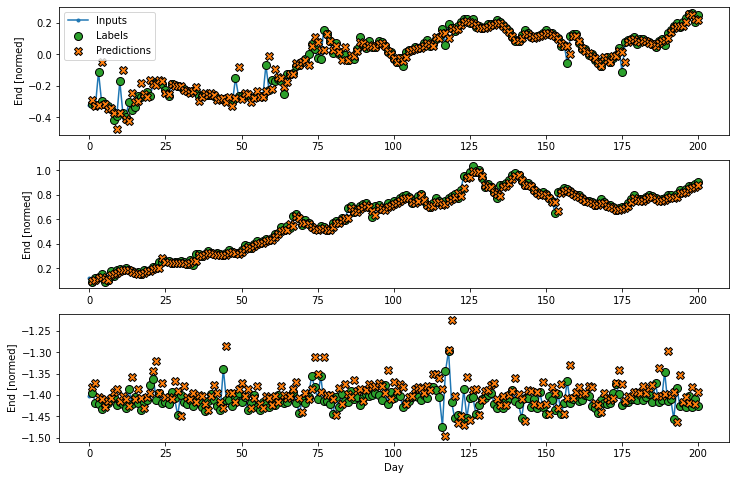

In [ ]:
wide_window.plot(linear)

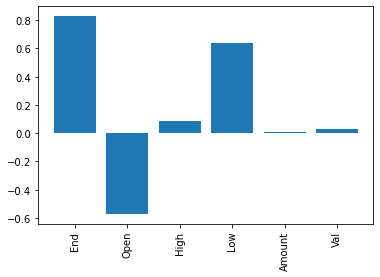

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#Single step Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
228/228 [==============================] - 2s 6ms/step - loss: 0.0735 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 2/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0211 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 3/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0213 - accuracy: 0.0000e+00 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 4/20
65/65 [==============================] - 0s 4ms/step - loss: 0.0109 - accuracy: 0.0000e+00


#Wide step Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 4s 15ms/step - loss: 0.0474 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 2/20
221/221 [==============================] - 3s 15ms/step - loss: 0.0202 - accuracy: 0.0000e+00 - val_loss: 0.0101 - val_accuracy: 0.0000e+00
Epoch 3/20
221/221 [==============================] - 3s 16ms/step - loss: 0.0199 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 4/20
59/59 [==============================] - 0s 6ms/step - loss: 0.0116 - accuracy: 0.0000e+00


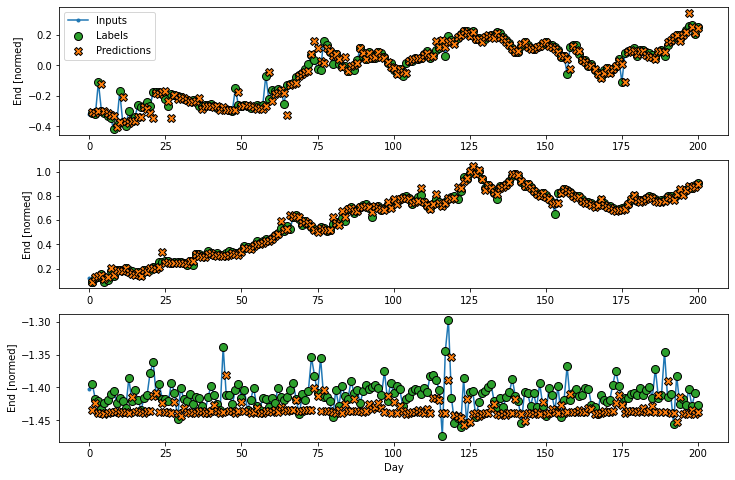

In [ ]:
wide_window.plot(dense)

Convolution network

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['End'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['End']

Text(0.5, 1.0, 'Given 3day as input, predict 1day into the future.')

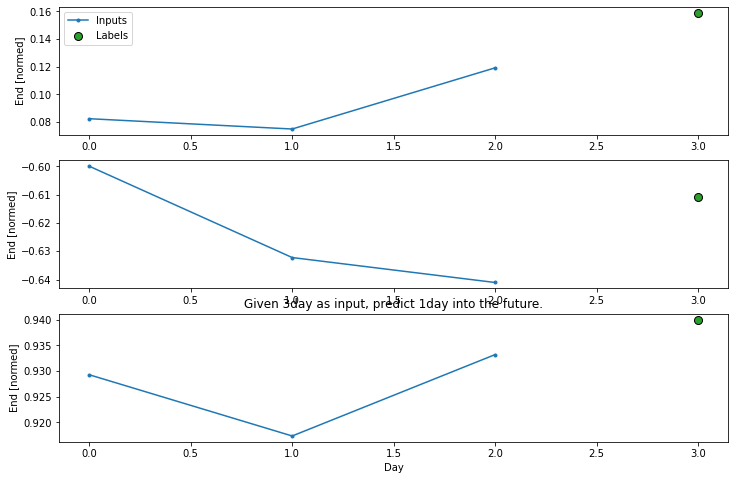

In [ ]:
conv_window.plot()
plt.title("Given 3day as input, predict 1day into the future.")

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu',
                           ),
    #tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


In [ ]:
conv = conv_model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 6, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

0.0023832482 0.13126151


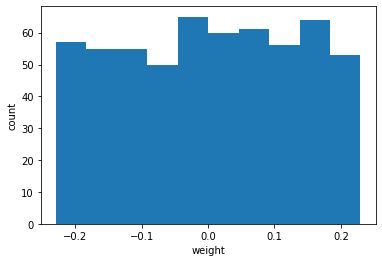

In [ ]:
plt.hist(conv_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

(0.0, 32.0)

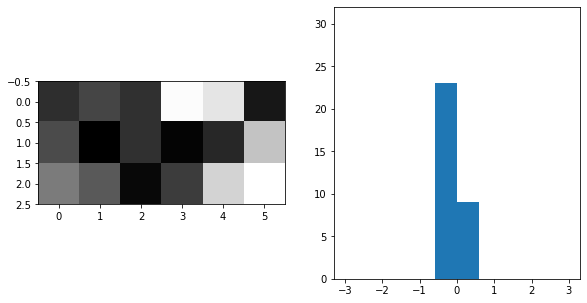

In [ ]:
conv_weight_single = conv_model.get_weights()[0]
plt.figure(figsize=(15, 5))
plt.subplot(131)
#plt.title(weight.shape)
plt.imshow(conv_weight_single[:,:,0], 'gray')
plt.subplot(132)
plt.hist(conv_model(conv_window.example[0]).numpy().ravel(), range=[-3,3])
plt.ylim(0,32)

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

65/65 [==============================] - 0s 4ms/step - loss: 0.0178 - accuracy: 0.0000e+00


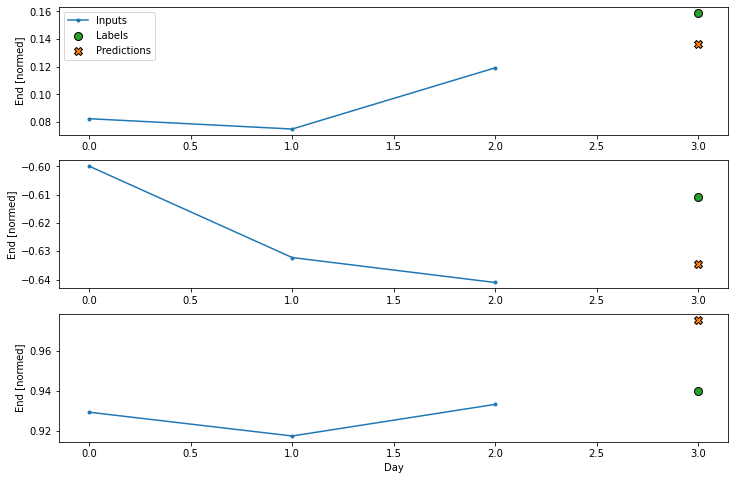

In [ ]:
conv_window.plot(conv_model)

In [ ]:
LABEL_WIDTH = 20
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['End'])

wide_conv_window

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Label column name(s): ['End']

Text(0.5, 1.0, 'Given 20day as input, predict 1day into the future.')

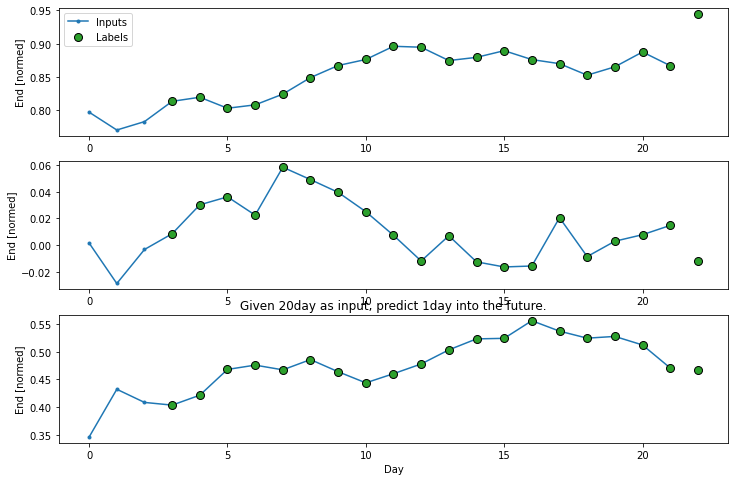

In [ ]:
wide_conv_window.plot()
plt.title("Given 20day as input, predict 1day into the future.")

In [ ]:
wide_conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(20,),
                           activation='relu',
                           ),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 200, 6)
Labels shape: (32, 200, 1)
Output shape: (32, 198, 1)


In [ ]:
wide_conv = wide_conv_model.layers[0]
print(wide_conv.weights[0].shape, wide_conv.weights[1].shape)

IndexError: ignored

In [ ]:
wide_conv_weights = wide_conv.weights[0].numpy()
print(wide_conv_weights.mean(), wide_conv_weights.std())

In [ ]:
wide_conv_weight = wide_conv_model.get_weights()[0]
plt.figure(figsize=(15, 5))
plt.subplot(132)
#plt.title(weight.shape)
plt.imshow(wide_conv_weight[:,:,0], 'gray')
plt.subplot(133)
plt.hist(wide_conv_model(wide_conv_window.example[0]).numpy().ravel(), range=[-3,3])
plt.ylim(0,200)

In [ ]:
history = compile_and_fit(wide_conv_model, wide_conv_window)

IPython.display.clear_output()
val_performance['Conv'] = wide_conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = wide_conv_model.evaluate(wide_conv_window.test, verbose=0)

In [ ]:
wide_conv_window.plot(conv_model)

RNN

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),     # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

SyntaxError: ignored

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 200, 6)
Output shape: (32, 200, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

59/59 [==============================] - 1s 18ms/step - loss: 0.0597 - mean_absolute_error: 0.1766


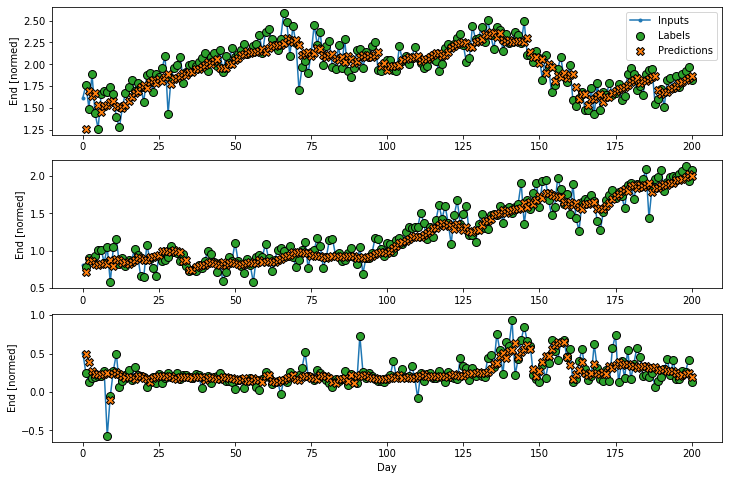

In [ ]:
wide_window.plot(lstm_model)

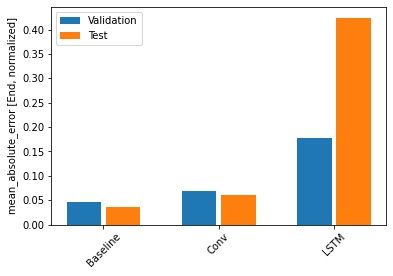

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
#del(val_performance['Dense'])
#del(performance['Dense'])

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [End, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
fig.set_size_inches(20,10)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0361
Conv        : 0.0615
LSTM        : 0.4247


#다중스텝모델

Total window size: 210
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [200 201 202 203 204 205 206 207 208 209]
Label column name(s): None

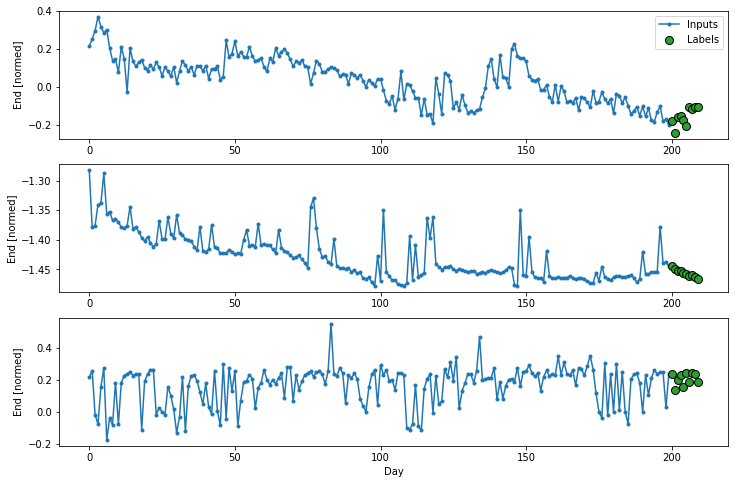

In [ ]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=200,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#Baseline
간단한 기준은 필요한 출력 타임스텝 수에 대해 마지막 입력 타임스텝을 반복

59/59 [==============================] - 0s 4ms/step - loss: 0.3036 - mean_absolute_error: 0.2564


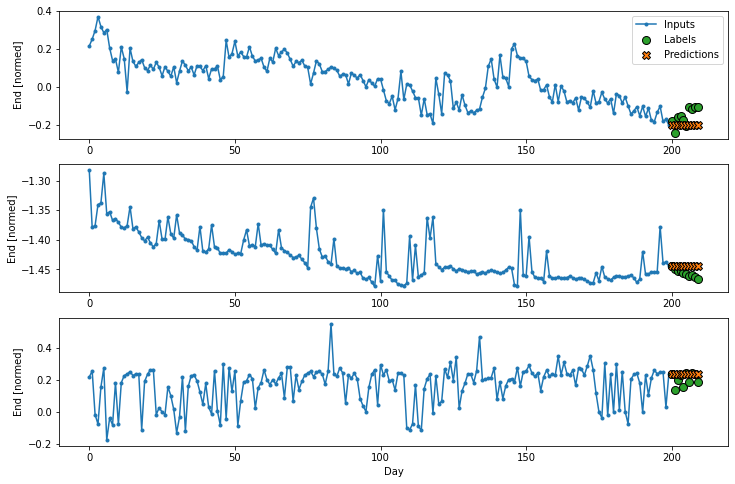

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

ValueError: ignored

#싱글샷 모델
한 번에 전체 시퀀스 예측을 수행하는 "싱글샷" 모델

linear model

59/59 [==============================] - 0s 4ms/step - loss: 0.1776 - mean_absolute_error: 0.2198


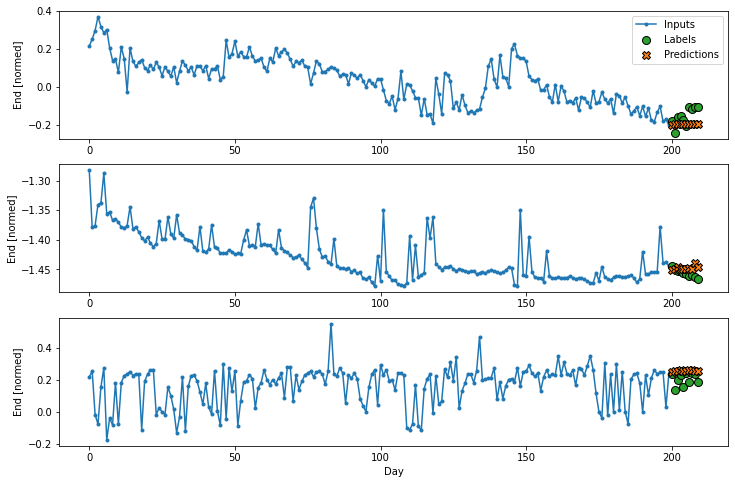

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

밀집 모델
입력과 출력 사이에 layers.Dense를 추가하면 선형 모델이 더 강력해지지만 여전히 단일 입력에 기반합니다.

59/59 [==============================] - 0s 4ms/step - loss: 0.2080 - mean_absolute_error: 0.2808


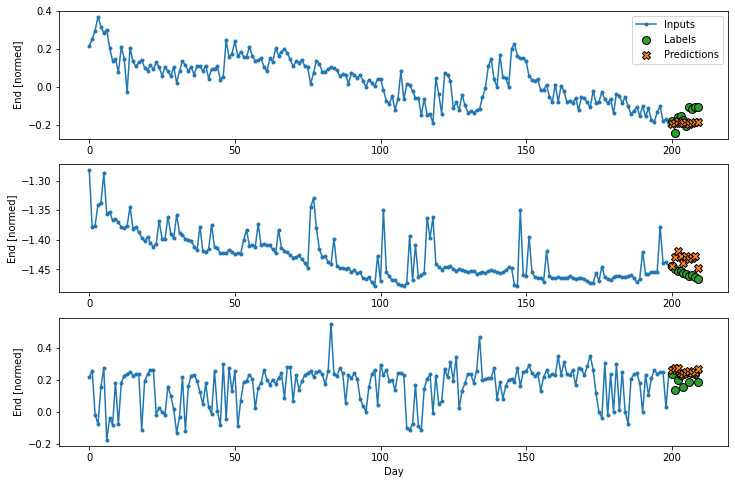

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Cnn

59/59 [==============================] - 0s 4ms/step - loss: 0.2071 - mean_absolute_error: 0.2841


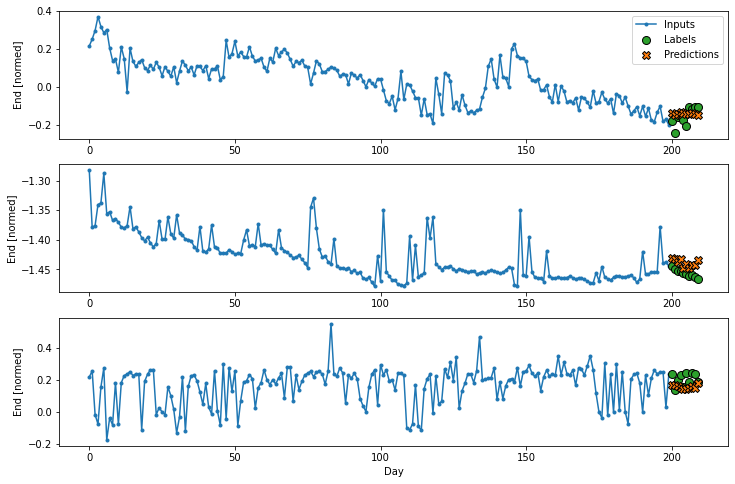

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

RNN

59/59 [==============================] - 1s 20ms/step - loss: 0.7065 - mean_absolute_error: 0.6795


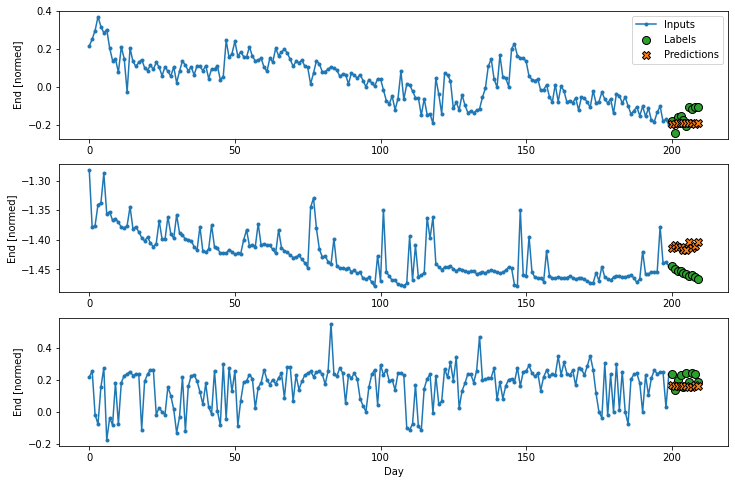

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

AR LSTM

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 6])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 6)


64/64 [==============================] - 1s 8ms/step - loss: 0.4629 - mean_absolute_error: 0.5474


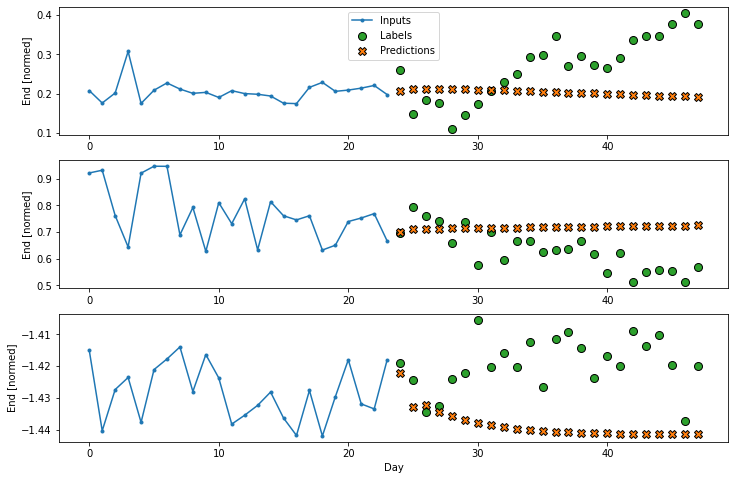

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

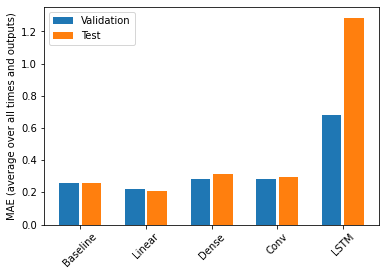

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

#del(multi_val_performance['Dense'])
#del(multi_performance['Dense'])
#del(multi_val_performance['Linear'])
#del(multi_performance['Linear'])

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.2564
Conv    : 0.2341
LSTM    : 1.3409


사실상 정확도를 판단하는건 MSE를 통해서 얼마나 실제값과 차이가 나냐 그걸 따져야하는 것 아닌가